In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm


from configurations import load_data, make_data_paths, save_fig, create_fig, set_font_sizes, apply_general_styles, make_params_dict
from sam.models import InductionHeadAttention, interpolation_initialization, InductionHeadAttentionSmaller , interpolation_initialization_smaller
from sam.dataset import get_sample

apply_general_styles()

# Optimal from Planted

In [179]:
# Parameters
vocab_size = 256 # Vocabulary size
seq_len = 128  # Sequence length
lr = 0.0001 # Learning rate

fix_names = ['vocab_size','seq_len','lr']

# alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6]  # Interpolation parameter for initialization (0: planted, 1: random)
alphas = [0.0,0.2,0.4,0.45,0.5]  # Interpolation parameter for initialization (0: planted, 1: random)
n_iters = 1

keys = ['train_loss', 'val_loss', 'val_accuracy', 'val_accuracy_sample']

results = {key: {alpha: [] for alpha in alphas} for key in keys}




for alpha in alphas:       
    var_names = ['alpha']
    params = make_params_dict(fix_names, var_names)
    summary = load_data('summary',experiment_name='small_induction_head', params=params,show=False)
    for key in keys:
        results[key][alpha] = summary[key]
      

results['step'] = summary['step']

for key in keys:
    print(f'{key}: {results[key][alpha].shape}')



train_loss: (81,)
val_loss: (81,)
val_accuracy: (81,)
val_accuracy_sample: (81,)


Figure saved on /u/c/cerazova/SAM/plots/2026-02 as optimal_from_planted_small_lr0.0001_seq_len128_vocab_size256.png


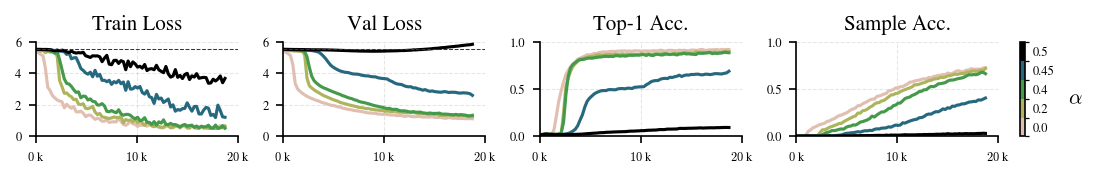

In [195]:
# Settings
ncols = len(keys)
cmap = 'gist_earth_r'
colors = plt.get_cmap(cmap)(np.linspace(0.1,1.0,len(alphas)))
set_font_sizes(conf='tight')
titles = ['Train Loss', 'Val Loss', 'Top-1 Acc.', 'Sample Acc.']

# Plotting
fig ,  axes = create_fig(ncols=ncols,size='double',h=0.15)

for i , (ax , key) in enumerate(zip(axes, keys)):
    for j , alpha in enumerate(alphas):
        ax.plot(results['step']/1000, results[key][alpha],color=colors[j],label=[fr'${alpha}$' if (i == ncols-1) else None])
    ax.set_title(titles[i])
    ax.grid(ls='--',alpha=0.2,c='gray',lw=0.5)
    xticks = ax.get_xticks()
    xticks_labels = [rf'${int(x)}$ k' for x in xticks]
    ax.set_xticks(xticks, labels=xticks_labels)
    
    if 'loss' in key:
        ax.set_ylim(0,6)
        ax.axhline(np.log(vocab_size), ls='--', c='purple', lw=0.5)
    if 'acc' in key:
        ax.set_ylim(0,1)
    
# ax.set_xscale('log')
ax.set_xlim(0,20)
# Create discrete colormap and colorbar with discrete colors
cmap = ListedColormap(colors)
bounds = np.arange(len(alphas) + 1)
norm = BoundaryNorm(bounds, cmap.N)

cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap,norm=norm),
    ax=ax, orientation='vertical',pad=0.05)

cbar.set_label(r'$\alpha$', rotation=0, labelpad=10)
# Ticks and labels
cbar.set_ticks(ticks=(np.arange(len(alphas)) + 0.5), labels= alphas)
cbar.ax.tick_params(length=0)  # Optional: remove tick lines for clarity

params = make_params_dict(fix_names)
save_fig(fig, 'optimal_from_planted_small',params=params,date=True)


# Optimal Model

In [303]:
# Parameters
vocab_size = 256 # Vocabulary size
seq_len = 128  # Sequence length
lr = 0.0001 # Learning rate
alpha = 0.1
iter = 1

states = ['init','fin']

fix_names = ['vocab_size','seq_len','lr']
var_names = ['alpha','iter'][:1]
params = make_params_dict(fix_names, var_names)


models = {}
for state in states:
    file_path , _, _ = make_data_paths(f'model_{state}', experiment_name= 'small_induction_head', params=params,ext='pt',base_dir='../data')     
    models[state] = torch.load(file_path)

for key in models[state].keys():
    print(key, models[state][key].shape)

beta_1 torch.Size([])
beta_2 torch.Size([])
beta_out torch.Size([])
embedding.weight torch.Size([256, 256])
positions.weight torch.Size([128, 128])
WQ1.weight torch.Size([128, 128])
WK1.weight torch.Size([128, 128])
WV1.weight torch.Size([256, 256])
WQ2.weight torch.Size([256, 256])
WK2.weight torch.Size([256, 256])
WV2.weight torch.Size([256, 256])


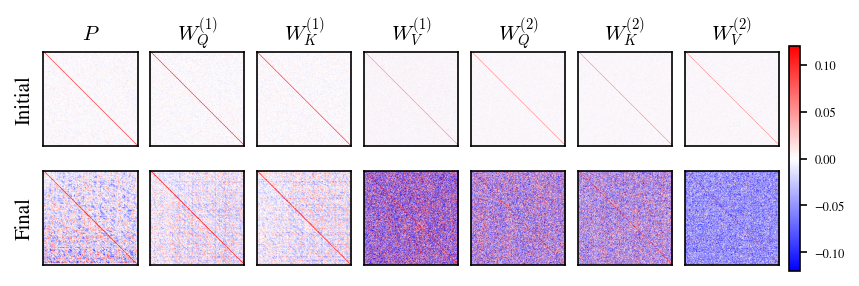

In [304]:
# Settings
keys = ['positions','WQ1','WK1','WV1','WQ2','WK2','WV2']
titles = [r'$P$',r'$W_Q^{(1)}$',r'$W_K^{(1)}$',r'$W_V^{(1)}$',r'$W_Q^{(2)}$',r'$W_K^{(2)}$',r'$W_V^{(2)}$']
ncols = len(keys)
# w_ratios = [ max(models['init'][f'{key}.weight'].shape) for key in keys]
# w_ratios = [1,3,3,1,1.5,1.5,1.5]
w_ratios = [1]*len(keys)
cmap = 'bwr'
# vlim = [0.05,0.05,0.05,0.05,0.05,0.05,0.05]
vlim = [0.12]*len(keys)
set_font_sizes(conf='tight')

# Create figure
fig , axes = create_fig(ncols=ncols,nrows=2,size='double',w=0.78,h=0.25,sharex=False,w_ratios=w_ratios)

for i, state in enumerate(states):
    for j , key in enumerate(keys):
        ax = axes[i,j]
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        # ax.set_axis_off()
        ax.spines[['bottom','left','top','right']].set_visible(True)
        if i == 0 : ax.set_title(titles[j])
        if j == 0: ax.set_ylabel(['Initial','Final'][i])
        variable = models[state][f'{key}.weight'].cpu().numpy()
        im = ax.imshow(variable,  cmap=cmap,vmin=-vlim[j],vmax=vlim[j])
        
        # ax.grid(ls='--',alpha=0.2,c='gray',lw=0.5)

# Add colorbar to the last column
cbar = fig.colorbar(im, ax=axes[:,-1], orientation='vertical',pad=0.1)

names = ['vocab_size','seq_len','lr','alpha']
params = make_params_dict(names)
# save_fig(fig, 'params_init_fin_small',params=params,date=True)

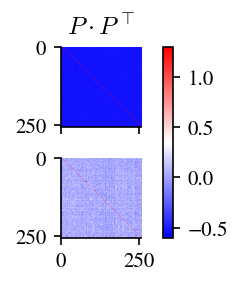

In [16]:
# Settings
cmap = 'bwr'

# Create Figure
fig , axes = create_fig(nrows=2,h=0.25,size='double',w=0.2,)

for i, state in enumerate(states):
    ax = axes[i]
    # P = models[state]['positions.weight'].cpu().numpy()
    # C = P @ P.T 
    WQ = models[state]['WQ2.weight'].cpu().numpy()
    WK = models[state]['WK2.weight'].cpu().numpy()
    im = ax.imshow(WQ@WK.T, cmap=cmap)#,vmin=-0.05,vmax=0.1)
    # ax.set_title(['Initial','Final'][i])
    # plt.colorbar(im, ax=ax)
    if i == 0: ax.set_title(r'$P \cdot P^\top $')
    

# Add colorbar to the last column
cbar = fig.colorbar(im, ax=axes, orientation='vertical',pad=0.1)
names = ['vocab_size','seq_len','lr','alpha']
params = make_params_dict(names)
# save_fig(fig, 'ppT_init_fin_small',params=params,date=True)

In [13]:
# Parameters
vocab_size = 256 # Vocabulary size
seq_len = 128  # Sequence length
lr = 0.0001 # Learning rate
alpha = 0.1
# iter = 1

states = ['init','fin']

fix_names = ['vocab_size','seq_len','lr']
var_names = ['alpha']
params = make_params_dict(fix_names, var_names)


models = {}
for state in states:
    file_path , _, _ = make_data_paths(f'model_{state}', experiment_name= 'small_induction_head', params=params,ext='pt',base_dir='../data')     
    models[state] = torch.load(file_path)

for key in models[state].keys():
    print(key, models[state][key].shape)

input , target, nsteps = get_sample(vocab_size,seq_len)
print(f'Input :{input}  ')
print(f'Target :{target}  ')


beta_1 torch.Size([])
beta_2 torch.Size([])
beta_out torch.Size([])
embedding.weight torch.Size([256, 256])
positions.weight torch.Size([128, 128])
WQ1.weight torch.Size([128, 128])
WK1.weight torch.Size([128, 128])
WV1.weight torch.Size([256, 256])
WQ2.weight torch.Size([256, 256])
WK2.weight torch.Size([256, 256])
WV2.weight torch.Size([256, 256])
Input :tensor([197, 212,  66, 145,   5,  81,  81,  97, 238,  54, 236, 177, 152,  90,
        194,  92, 208,  31, 237,  67,  35,  97, 126,  27, 134,  42,  46, 172,
         34,  96, 212,  25, 156, 151,  98, 133,  27,  39,  55, 136,  68,  71,
        153, 218, 194,  80, 100,  55, 100,   5, 121, 151, 172, 228, 185, 183,
        102,  77,  34,  18, 111,  44, 150,  82,  85,  82, 186,  55,  90,  40,
         25, 116, 217,  63,  98,  16, 198, 170, 216, 174,  96, 163,  46, 236,
        255, 240,  24, 110,  42, 169,  75, 124, 151,  48, 177, 169, 130, 126,
          2, 107,  76, 177,  67,  33, 225,  33,  98, 119, 110,  70,  65, 220,
        239,  57,

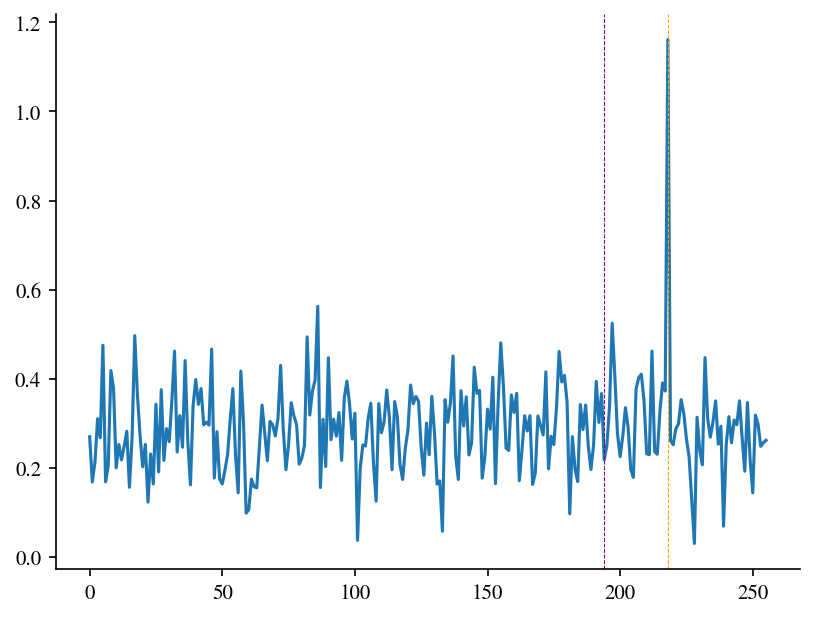

In [14]:
model = InductionHeadAttentionSmaller(vocab_size=vocab_size, seq_len=seq_len)
model.load_state_dict(models['fin'])

interpolation_initialization_smaller(model,alpha=0.3)

model.eval()


logits = model(input.unsqueeze(0))[0].detach().cpu().numpy()

plt.plot(logits)
plt.axvline(target, ls='--', c='purple', lw=0.5)
plt.axvline(input[-1], ls='--', c='orange', lw=0.5)

# Optimizers


In [295]:
# Parameters
vocab_size = 256 # Vocabulary size
seq_len = 128  # Sequence length
lr = 0.005 # Learning rate
alpha = 0.3
gamma = 0.0

fix_names = ['vocab_size','seq_len','lr']

configurations = [('SGD',0.0),
                  ('SAM',0.1),
                  ('SAM',0.2),
                  ('SAM',0.3),
                  ('SAM',0.4),]
                #   ('adam',0.0),]
                #   ('SAM',0.2),]
                #   ('SAM',0.3)]

results = []
aligments = []
for opt, rho in configurations:
    print(f'Optimizer: {opt}, Rho: {rho}')
    var_names = ['alpha','rho','gamma','opt']
    params = make_params_dict(fix_names, var_names)
    results.append(load_data('summary',experiment_name='post_small_induction_head', params=params,show=False))
    aligments.append(load_data('aligment',experiment_name='post_small_induction_head', params=params,show=False))


for key in results[0].keys():
    print(key, results[0][key].shape)

for key in aligments[0]['overlap'].keys():
    print(key,)


ov_list = []
for key in aligments[0]['overlap'].keys():
    if 'weight' in key and not 'embedding' in key:
        key = key.replace('.weight','')
        ov_list.append(key)

print(ov_list)

Optimizer: SGD, Rho: 0.0
Optimizer: SAM, Rho: 0.1
Optimizer: SAM, Rho: 0.2
Optimizer: SAM, Rho: 0.3
Optimizer: SAM, Rho: 0.4
step (51,)
train_loss (51,)
val_loss (51,)
val_accuracy (51,)
val_accuracy_sample (51,)
beta_1
beta_2
beta_out
embedding.weight
positions.weight
WQ1.weight
WK1.weight
WV1.weight
WQ2.weight
WK2.weight
WV2.weight
['positions', 'WQ1', 'WK1', 'WV1', 'WQ2', 'WK2', 'WV2']


Figure saved on /u/c/cerazova/SAM/plots/2026-02 as metric_conv_to_teach_small_alpha0.3_lr0.005_seq_len128_vocab_size256.png


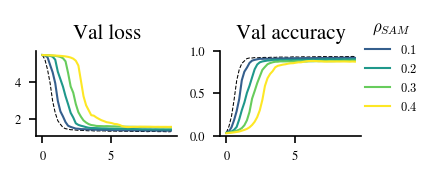

Figure saved on /u/c/cerazova/SAM/plots/2026-02 as overlap_conv_to_teach_small_alpha0.3_lr0.005_seq_len128_vocab_size256.png


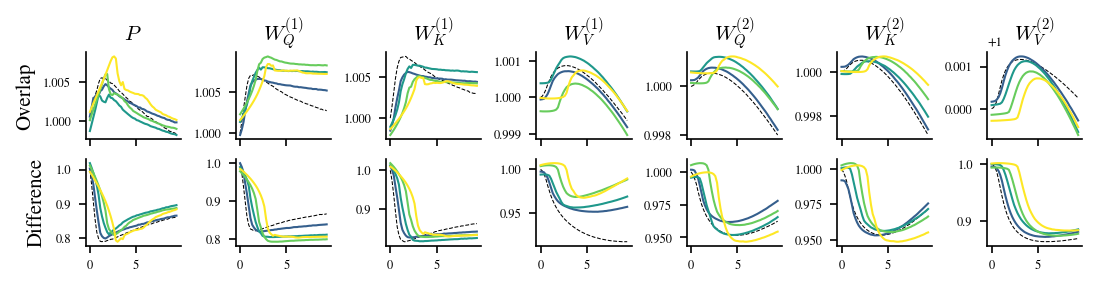

In [298]:
# Settings
step = results[0]['step']
cmap = 'viridis'
colors = plt.get_cmap(cmap)(np.linspace(0.3,1.0,len(configurations)-1))

set_font_sizes(conf='tight')

# Plots Loss - Acc
fig , axes = create_fig(ncols=2,size='single',w=0.8,h=0.30)


for j , key in enumerate(['val_loss','val_accuracy']):
    ax = axes[j]
    # if j == 0: ax.set_yscale('log')
    if j == 1 : ax.set_ylim(0,1)
    ax.set_title(key.replace('_',' ').title().capitalize())
    for i , (opt,rho) in enumerate(configurations):
        if opt == 'SGD':
            setup = {'ls':'--','c':'k','lw':0.5}
        elif opt == 'adam':
            setup = {'ls':':','c':'k','lw':0.5}
        else:
            setup = {'ls':'-','c':colors[i-1],'lw':1.,'label':rf'${rho}$'}

        ax.plot(step/1000,results[i][key], **setup)

axes[1].legend(title=r'$\rho_{SAM}$',frameon=False,loc=(0.99,0.2))



names = ['vocab_size','seq_len','lr','alpha']
params = make_params_dict(names)
save_fig(fig, 'metric_conv_to_teach_small',params=params,date=True)

plt.show()


# Plots Overlaps
ncols = len(ov_list)
fig , axes = create_fig(ncols=ncols,nrows=2,size='double',h=0.25,w=1,sharey=False)

for k , lb in enumerate(['overlap','difference']):
    for i, key in enumerate(ov_list):
        ax = axes[k,i]
        
        title = rf'$W_{key[1]}^{{({key[2]})}}$' if not key == 'positions' else r'$ P$'
        if k==0: ax.set_title(title)
        if i == 0: ax.set_ylabel(['Overlap','Difference'][k])
        # ax.set_ylim(top=1,bottom=0.9)
        for j , (opt,rho) in enumerate(configurations):
            if opt == 'SGD':
                setup = {'ls':'--','c':'k','lw':0.5}
            elif opt == 'adam':
                setup = {'ls':':','c':'k','lw':0.5}
            else:
                setup = {'ls':'-','c':colors[j-1],'lw':1.,'label':rf'${rho}$'}
            norm = aligments[0][lb][f'{key}.weight'][0]
            ax.plot(step/1000, aligments[j][lb][f'{key}.weight']/norm, **setup)

save_fig(fig, 'overlap_conv_to_teach_small',params=params,date=True)

plt.show()
